# Xarray: N-D labeled arrays and datasets

Xarray introduces labels in the form of dimensions, coordinates and attributes on top of raw NumPy-like arrays, which allows for a more intuitive and concise code.

xarray originated in the geosciences and is based on the [netCDF](https://www.unidata.ucar.edu/software/netcdf/docs/faq.html#What-Is-netCDF) data model, however it does not seem to contain any bagage specific to that field.

### Content
* [DataArray](#DataArray)
* [Dataset](#Dataset)
* [Reasons to use xarray](#Reasons-to-use-xarray)

## DataArray

`xarray.DataArray` allows for n-dimensional array with labeled dimensions and coordinates.

As example we create a 2-dimensional `DataArray`. We name the dimensions x and y and provide the coordinates along these two dimensions. Additionally we set some metadata attributes on what the array represents (name, long_name, units, descriptions). Likewise we set attributes of the coordinates.

In [1]:
import xarray as xr
import numpy as np

In [2]:
data = xr.DataArray(
    np.random.randn(2, 3),
    dims=('x', 'y'),
    coords={'x': [10, 20], 'y': [5, 10, 15]},
    name='velocity',
    attrs={
        'long_name': 'random velocity',
        'units': 'm/s',
        'description': 'A random variable created as an example',
    },
)

# we can also pass attributes to the dimesions
data.x.attrs = {'units': 'm', 'long_name': 'x-position'}
data.y.attrs = {'units': 'm', 'long_name': 'y-position'}

data

<xarray.DataArray 'velocity' (x: 2, y: 3)>
array([[-2.12986688,  1.17893016,  1.20629703],
       [ 0.85204217,  0.19158319,  1.43480901]])
Coordinates:
  * x        (x) int64 10 20
  * y        (y) int64 5 10 15
Attributes:
    long_name:    random velocity
    units:        m/s
    description:  A random variable created as an example

In [3]:
data.dims

('x', 'y')

In [4]:
data.coords

Coordinates:
  * x        (x) int64 10 20
  * y        (y) int64 5 10 15

In [5]:
data.attrs

{'long_name': 'random velocity',
 'units': 'm/s',
 'description': 'A random variable created as an example'}

In [6]:
data['x'].attrs

{'units': 'm', 'long_name': 'x-position'}

### Indexing
We can use numpy indexing and pandas indexing. Additionally, we can select by coordinate value or index.

In [7]:
data[0, :].values

array([-2.12986688,  1.17893016,  1.20629703])

In [8]:
data.loc[10, 5].values

array(-2.12986688)

In [9]:
data.isel(x=0).values

array([-2.12986688,  1.17893016,  1.20629703])

In [10]:
data.sel(x=10).values

array([-2.12986688,  1.17893016,  1.20629703])

### Computation
* Operations work as in numpy.  
* Aggregation operations can make use of the dimension names.  
* Broadcasting is based on dimension names, so we don't need to insert dummy dimensions for axis alignment, or worry about the order of the dimensions!

In [11]:
# note that attrs are dropped on any compution or aggregation, 
# unless the option keep_attrs is set to True
data + 10

<xarray.DataArray 'velocity' (x: 2, y: 3)>
array([[ 7.87013312, 11.17893016, 11.20629703],
       [10.85204217, 10.19158319, 11.43480901]])
Coordinates:
  * x        (x) int64 10 20
  * y        (y) int64 5 10 15

In [12]:
with xr.set_options(keep_attrs=True):
    print(data + 10)

<xarray.DataArray 'velocity' (x: 2, y: 3)>
array([[ 7.87013312, 11.17893016, 11.20629703],
       [10.85204217, 10.19158319, 11.43480901]])
Coordinates:
  * x        (x) int64 10 20
  * y        (y) int64 5 10 15
Attributes:
    long_name:    random velocity
    units:        m/s
    description:  A random variable created as an example


In [13]:
# transpose
data.T

<xarray.DataArray 'velocity' (y: 3, x: 2)>
array([[-2.12986688,  0.85204217],
       [ 1.17893016,  0.19158319],
       [ 1.20629703,  1.43480901]])
Coordinates:
  * x        (x) int64 10 20
  * y        (y) int64 5 10 15
Attributes:
    long_name:    random velocity
    units:        m/s
    description:  A random variable created as an example

In [14]:
# average along y-dimension
data.mean(dim='y')

<xarray.DataArray 'velocity' (x: 2)>
array([0.0851201 , 0.82614479])
Coordinates:
  * x        (x) int64 10 20

In [15]:
# broadcasting
a = xr.DataArray(np.random.randn(3), dims=('x1'))
b = xr.DataArray(np.random.randn(4), dims=('x2'))
a + b

<xarray.DataArray (x1: 3, x2: 4)>
array([[-1.35420622, -0.20058074, -1.11268736, -0.29163158],
       [-1.05416614,  0.09945933, -0.81264729,  0.00840849],
       [-0.26200564,  0.89161984, -0.02048678,  0.800569  ]])
Dimensions without coordinates: x1, x2

### Plotting
Plotting uses the unit and name / long_name attributes if available. Plotting is available for 0, 1, and 2-dimensional data.

In [16]:
# 2d plot
data.plot();

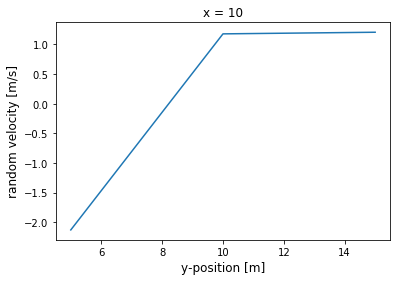

In [17]:
# 1d plot
data.sel(x=10).plot();

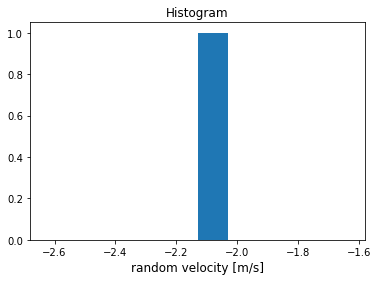

In [18]:
# 0d plot
data.sel(x=10, y=5).plot();

### Conversion to/from pandas
A `xarray.DataArray` can be converted to/from `pandas.Series` or `pandas.DataFrame`. Since in our case the array is 2-dimensional, a muliindex is created on the pandas side. The meta-information is obviously lost in the conversion.

In [19]:
series = data.to_series()
series

x   y 
10  5    -2.129867
    10    1.178930
    15    1.206297
20  5     0.852042
    10    0.191583
    15    1.434809
Name: velocity, dtype: float64

In [20]:
series.to_xarray()

<xarray.DataArray 'velocity' (x: 2, y: 3)>
array([[-2.12986688,  1.17893016,  1.20629703],
       [ 0.85204217,  0.19158319,  1.43480901]])
Coordinates:
  * x        (x) int64 10 20
  * y        (y) int64 5 10 15

In [21]:
frame = data.to_dataframe()
frame

velocity
x  y           
10 5  -2.129867
   10  1.178930
   15  1.206297
20 5   0.852042
   10  0.191583
   15  1.434809

In [22]:
frame.to_xarray()

<xarray.Dataset>
Dimensions:   (x: 2, y: 3)
Coordinates:
  * x         (x) int64 10 20
  * y         (y) int64 5 10 15
Data variables:
    velocity  (x, y) float64 -2.13 1.179 1.206 0.852 0.1916 1.435

### Reading and writing files

In [23]:
data.to_netcdf('data.nc')

In [24]:
xr.open_dataset('data.nc')

<xarray.Dataset>
Dimensions:   (x: 2, y: 3)
Coordinates:
  * y         (y) int32 5 10 15
  * x         (x) int32 10 20
Data variables:
    velocity  (x, y) float64 ...

## Dataset

`xarray.Datasets` is a dict-like container of aligned `DataArray` objects, sharing the same coordinate system. We can think of it as n-dimensional generalization of a `pandas.DataFrame`

In [25]:
ds = xr.Dataset({'foo': data, 'bar': ('x', [1, 2]), 'baz': np.pi})
ds

<xarray.Dataset>
Dimensions:  (x: 2, y: 3)
Coordinates:
  * x        (x) int64 10 20
  * y        (y) int64 5 10 15
Data variables:
    foo      (x, y) float64 -2.13 1.179 1.206 0.852 0.1916 1.435
    bar      (x) int64 1 2
    baz      float64 3.142

In [26]:
ds.to_dataframe()

foo  bar       baz
x  y                          
10 5  -2.129867    1  3.141593
   10  1.178930    1  3.141593
   15  1.206297    1  3.141593
20 5   0.852042    2  3.141593
   10  0.191583    2  3.141593
   15  1.434809    2  3.141593

## Reasons to use xarray

#### 1) Multidimensional data
`pandas.DataFrame` and `Series` are only convenient for tabular (1d) data where we have one dimension (the rows) with coordinates (the index) and one or more measurables (the columns). For a multidimensional example think of the surface temperature as a function of position and time $T(x,y,t)$, thus 3 dimensions. Here, we either have to use a multiindex (x,y,t) or make the dimensions part of the measurables (the columns).  
Here `xarray.DataArray` (for one measurable) and `xarray.Dataset` (for multiple measurables with aligned coordinates) offer more convience for indexing operations and are more efficient in terms of memory and computation.

#### 2) Support for metainformation 
With pandas.DataFrames we have typically give abbreviated names to the columns, in order to more conviently access them. However, 
Another advantage over DataFrames, even for tabular data,  is the support for metainformation for storing units, description and other information that is relevant for understanding the data.

#### 3) Support for dask
xarray provides direct support for dask.

In [27]:
%load_ext watermark
%watermark -v -m -p numpy,xarray

CPython 3.7.4
IPython 7.6.1

numpy 1.17.2
xarray 0.14.0

compiler   : GCC 9.2.0
system     : Linux
release    : 4.4.0-43-Microsoft
machine    : x86_64
processor  : 
CPU cores  : 4
interpreter: 64bit
